## Leaky integrated firing neuron model  
## Few feautures :
### Spatial network, no memory term but exponential decay of cumulative dose

This is a minor change of the Dodds and Watts model  
Implement adaptive rewiring and generate statistics

In [21]:
#importing the required libraries

import networkx as nx
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
# from numba import jit #numba precomplier to make the code faster
import pandas as pd
import copy
import warnings
warnings.filterwarnings('ignore')

# Variables used in the simulation

In [22]:
N = 100
gamma = 1 #decay of cumulative dose per unit time (second)
T = 100 #total number of seconds
dt = 0.05 #seconds
'''number of simulation steps is T/dt'''

'''Dodds watts parameters'''
p = 1 #rate of dose transfer (per unit time (second))
p = p*dt #rate of dose transfer per unit simulation step
r = 1/dt
r = r*dt
rho = 1/dt
rho = rho*dt
# r = 0.5
# r = r*dt

d_star = 1
# dose_quantity = 1
D_ini = 3

'''network parameters'''
circ_rad = 100 #for a network in which each node is connected to other nodes withing a circle of radius circ_rad
nn = 7 #the number of nearest neighbours(i.e. k) in knn
average_degree = 6
total_edges = N*2

'''rewiring parameters'''
w_minus = 1
w_minus = w_minus*dt
# p_rew = 5 #rate of rewiring(per unit time(second))
# p_rew = p_rew*dt

# Creating the network. 
### The network outputs coordinates, distance matrix, edge_list and adjacency matrix

In [23]:
'''
obtains the number of nodes N
generates N points
calculates euclidean distance between each pair of points
returns the coordinates of the points and the distance matrix which is N*N
'''
def calc_dist(N) :
    coords = []
    for counter in range(N) :
        coords.append((N*np.random.random(),N*np.random.random()))

    dist_mat = scipy.spatial.distance.cdist(coords,coords)
    return dist_mat,coords

### 1. metric network

In [24]:
'''network = connect to points withing a circle of radius'''
#creates a link between points/nodes which satisfies the conditions of the network
def coupling(dist_mat,circ_rad) :
    edge_list = []
    edge_mask = (dist_mat<circ_rad) & (dist_mat>0)
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(edge_mask))))
#     print(type(np.ndarray.tolist(np.transpose(np.where(edge_mask)))))
    return edge_list

### 2. K nearest neighbour network

In [25]:
'''network = knn'''
def knn(dist_mat,nn,N) :
    near_neigh = np.argsort(dist_mat)
    selec_near_neigh = np.zeros((N,nn))
    selec_near_neigh = near_neigh[:,0:nn+1]

    edge_list = []
    for i in range(N) :
        for j in range(1,nn+1) :
            link = [i,selec_near_neigh[i,j]]
            edge_list.append(link)

    return edge_list

### 3. Random Network : GNP type

In [26]:
'''random network'''
def rand_network(average_degree,N) :
    z1 = np.random.uniform(size = (N,N))
    E,F = np.meshgrid(np.arange(0,N),np.arange(0,N))
    mask = ((average_degree/N) > z1) & (E!=F)
    adjacency_matrix = np.int64(np.zeros(shape=(N,N)))
    adjacency_matrix[mask] = np.int64(1)
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adjacency_matrix==1))))
    return edge_list,adjacency_matrix

### 4. Random Network : GNM type

In [27]:
def rand_net_gnm(total_edges,N) :
    the_graph = nx.gnm_random_graph(N, total_edges,directed=True)
    adjacency_matrix = nx.adjacency_matrix(the_graph)
    adjacency_matrix = np.asarray(adjacency_matrix.todense())
    np.fill_diagonal(adjacency_matrix,0)
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adjacency_matrix==1))))
    return edge_list

# Function defintions required for the main part of the script

In [28]:
# # @jit(nopython=True)
# '''infecting the left part of space.'''
# def left_part_infec(N) :
#     x_coord = []
#     y_coord = []
#     for j in range(len(coords)) :
#         x_coord.append(coords[j][0])
#         y_coord.append(coords[j][1])
#     x_coord = np.asarray(x_coord)
#     y_coord = np.asarray(y_coord)
#     points = np.asarray(np.where(x_coord<(N/5))) 
#     indi_state[points.T] = 2

#     return indi_state

In [29]:
'''infecting connected nodes'''
def InfectNetworkNeighbors(net,seed_node,init_infected_nodes):
     # if in bulk find one node randomly, and infect its neighbours
    infected_nodes = set()
    candidate_nodes = set()
    explored_nodes = set()

    #pick the seed node
    infected_nodes.add(seed_node)
    explored_nodes.add(seed_node)

    curr_node=seed_node

    #add its neighbors to the list of candidates
    for n in net.neighbors(curr_node):
        candidate_nodes.add(int(n))
    #print( curr_node)
    #print( candidate_nodes)

    #while we need to select more nodes...
    while len(infected_nodes) < init_infected_nodes:

        #if there are candidate nodes, select one of them
        if(len(candidate_nodes) > 0):
            new_node = np.random.choice(list(candidate_nodes),1)[0]
            infected_nodes.add(new_node)
            candidate_nodes.remove(new_node)

        elif len(infected_nodes - explored_nodes) > 0:
            curr_node = np.random.choice(list(infected_nodes -
            explored_nodes),1)[0]
            explored_nodes.add(curr_node)
            for n in set(net.neighbors(curr_node)) - infected_nodes:
                candidate_nodes.add(n)

        else:
#             print('Initial node infection step failed')
            return None
    return infected_nodes

In [30]:
''' function to transfer doses'''
# @jit(nopython=True)
def dose(adj_mat,p,partner_state_prev,d) :

    z1 = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    
    dose_transfer_mask = p > z1
    mod_adj_mat = np.multiply(adj_mat,z1) #modifying adjacency matrix to include the proability of dose transfer
    dose_mask = (p>mod_adj_mat) & (adj_mat!=0) & (partner_state_prev == 2)
    d[dose_mask] = dose_quantity #whenever it is proabable, dose transfer occurs
    
    return d

In [31]:
def rew(p_rew,adjacency_matrix,indi_state_for_rew_prev,OD_mesh2,lamb_da) :
    
    z1_rew_prew = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    z1_rew_lambda = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    
    rew_mask_plus = (p_rew > z1_rew_prew)  & (indi_state_for_rew_prev == 1)
    #create links. Dont break any.
    adjacency_matrix[rew_mask_plus] = 1
    rew_mask_minus1 = (w_minus > z1_rew_prew) & (indi_state_for_rew_prev == 2)
    #break links. Dont create any.
    adjacency_matrix[rew_mask_minus1] = 0
    rew_mask_minus2 = ((lamb_da*OD_mesh2) > z1_rew_lambda) & (indi_state_for_rew_prev == 1)
    adjacency_matrix[rew_mask_minus2] = 0
    
    np.fill_diagonal(adjacency_matrix,0)
    
    return adjacency_matrix

In [32]:
'''function to update cumulative doses'''
def cumu_dose(d,D_prev,gamma) :
    I = d.sum(axis=1).reshape(N,1)
#     I = 0
    D = (D_prev - (gamma*D_prev*dt)) + I
    return D

In [33]:
'''function to update the states of the nodes of the system'''
def upd_indi_state(D,d_star,indi_state_prev) :
    
    z2 = np.random.uniform(size=(N,1))
    z3 = np.random.uniform(size=(N,1))
    
    indi_state = indi_state_prev
    
    indi_state_mask1 = (D>=d_star) & (indi_state_prev==1)
    indi_state[indi_state_mask1] = 2
    
    indi_state_mask21 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho>=z3)
    indi_state[indi_state_mask21] = 1
    
    indi_state_mask22 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho<z3)
    indi_state[indi_state_mask22] = 3
    
    indi_state_mask23 = (D<d_star) & (indi_state_prev==2) & (r<z2)
    indi_state[indi_state_mask23] = 2
    
    return indi_state

In [34]:
'''function to get/identify the infected nodes and the suceptible nodes'''
def states(indi_state) :
    infec_indi = []
    suscep_indi = []
    infec_indi = np.transpose(np.where(indi_state==2))
    suscep_indi = np.transpose(np.where(indi_state==1))
    return infec_indi,suscep_indi

In [35]:
def networkx_graph(coords,edge_list) :
    G = nx.DiGraph()
    pos = {(i): (coords[i][0],coords[i][1]) for i in range(N)}
    G.add_nodes_from(pos.keys())
    G.add_edges_from(edge_list)
    return G

In [36]:
def edge_from_adj_mat(adj_mat_list,q):
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adj_mat_list[q]==1))))
    return edge_list

# Choose which network you want in the program
### Coupling network of knn network?

In [37]:
# '''returns coordinates, distance matrix, edge_list and the adjacency matrix'''

# dist_mat,coords = calc_dist(N) #node placement

# # edge_list = coupling(dist_mat,circ_rad)
# # edge_list = knn(dist_mat,nn,N)
# # edge_list = rand_network(average_degree,N)
# edge_list = rand_net_gnm(total_edges,N)

# org_adj_mat = np.int64(np.zeros((N,N)))
# for i in range(len(edge_list)):
#     org_adj_mat[edge_list[i][0],edge_list[i][1]] = np.int64(1)

# The main part of the script

In [38]:
#infected state time series data frame
#columns indicate the time steps
timeseries_infec_frac = pd.DataFrame()

#in degree as columns and rows as nodes
timeseries_in_degree = pd.DataFrame() 

#out degree as columns and rows as nodes
timeseries_out_degree = pd.DataFrame()

#strongly connected components as columns
timeseries_connec_comps = pd.DataFrame()

In [39]:
p_rew_vals = [0.01,0.1,1,10]
start_vals = [1,10]
dose_quantity_vals = [0.1,2]

# p_rew_vals = [10]
# start_vals = [10]
# dose_quantity_vals = [0.1]

In [40]:
for sim in range(70,70+50) :
    '''returns coordinates, distance matrix, edge_list and the adjacency matrix'''
    dist_mat,coords = calc_dist(N) #node placement
    edge_list = rand_net_gnm(total_edges,N)
    org_adj_mat = np.int64(np.zeros((N,N)))
    for i in range(len(edge_list)):
        org_adj_mat[edge_list[i][0],edge_list[i][1]] = np.int64(1)
        
    df_row = 0
    for p_rew in p_rew_vals : #rate of rewiring (per unit time (second))
        lamb_da = p_rew/10
        lamb_da = lamb_da*dt
        p_rew = p_rew*dt
        for start in start_vals : #rate of dose transfer (per unit time (second))
            for dose_quantity in dose_quantity_vals : #number of nodes to infect initially
                print('(sim,lamb_da,p_rew,w_minus,start,dose_quantity) = ', (sim,lamb_da/dt,p_rew/dt,w_minus/dt,start,dose_quantity))

                '''clearing exsiting data frames and creating new ones '''
                timeseries_infec_frac = pd.DataFrame()
                timeseries_in_degree = pd.DataFrame()
                timeseries_out_degree = pd.DataFrame()
                timeseries_connec_comps = pd.DataFrame()

                q = 0 #to generate new edge_list from the new adjacency matrix 
                t = np.arange(0,T,dt)

    #             numpy_array = np.zeros((N,len(t)),dtype = np.int64) #stores the states of the nodes. Rows are nodes and columns are time steps
                D_array = np.zeros((N,len(t))) #stores the cumulative doses. Rows are nodes and columns are time steps

                adj_mat_list = []
                adj_mat = copy.deepcopy(org_adj_mat)
                adj_mat_new = copy.deepcopy(adj_mat)
                adj_mat_list.append(adj_mat_new) #list of arrays which shows the time series of the adjacency matrix

                #coords remain the same. Get new edge_list from the latest adjacency matrix
                edge_list = edge_from_adj_mat(adj_mat_list,q)
                G = networkx_graph(coords,edge_list) #networkx graph

                '''from G, obtain the in degree and the out degree'''
                timeseries_in_degree.loc[:,0] = np.asarray([val for (node, val) in G.in_degree()])
                timeseries_out_degree.loc[:,0] = np.asarray([val for (node, val) in G.out_degree()])

                '''strongly and weekely connected components'''
                timeseries_connec_comps.loc[0,0] = nx.number_connected_components(G.to_undirected())

                '''choosing initially infected nodes'''
                indi_state = np.random.randint(1,2,size=(N,1))
                infected_nodes = None
                while infected_nodes is None : #infecting 'start' number of network neighbours
                    infected_nodes = InfectNetworkNeighbors(G,np.random.randint(N),start)
                print(infected_nodes)
                infected_nodes = np.asarray(list(infected_nodes)).reshape(len(infected_nodes),1)
                indi_state[infected_nodes[:,0],0] = 2

                A,B = np.meshgrid(indi_state,indi_state) 
                partner_state = A
                indi_state_for_rew = B

    #             numpy_array [:,0] = indi_state[:,0]

                indi_state_prev = indi_state
                partner_state_prev = partner_state
                indi_state_for_rew_prev = indi_state_for_rew

                d = np.zeros((len(adj_mat),len(adj_mat[0])))

                D = np.zeros((N,1))
                D[np.where(indi_state==2)] = D_ini
                D_array[:,0] = D[:,0]
                D_prev = D

                infec_frac = np.count_nonzero(indi_state == 2)/N
                timeseries_infec_frac.loc[df_row,0] = infec_frac
                '''the main part of the simulation'''
                counter = 0
                df_col = 1
                for t in np.arange(dt,T,dt) :
                    q = q + 1 
                    counter = counter + 1
                    infec_indi = []
                    suscep_indi = []
                    d = np.zeros((len(adj_mat),len(adj_mat[0])))
                    d = dose(adj_mat,p,partner_state_prev,d)

                    OD_array = np.asarray([val for (node, val) in G.out_degree()])
                    OD_mesh1,OD_mesh2 = np.meshgrid(OD_array,OD_array)
                    adj_mat = rew(p_rew,adj_mat,indi_state_for_rew_prev,OD_mesh2,lamb_da)
                    adj_mat_new = copy.deepcopy(adj_mat)
                    adj_mat_list.append(adj_mat_new)

                    #coords remain the same. Get new edge_list from the latest adjacency matrix
                    edge_list = edge_from_adj_mat(adj_mat_list,q)
                    G = networkx_graph(coords,edge_list) #networkx graph

                    '''from G, obtain the in degree and the out degree'''
                    timeseries_in_degree.loc[:,df_col] = np.asarray([val for (node, val) in G.in_degree()])
                    timeseries_out_degree.loc[:,df_col] = np.asarray([val for (node, val) in G.out_degree()])

                    '''strongly and weekely connected components'''
                    timeseries_connec_comps.loc[df_row,df_col] = nx.number_connected_components(G.to_undirected())

                    D = cumu_dose(d,D_prev,gamma)
                    D_array[:,counter] = D[:,0]

                    indi_state = upd_indi_state(D,d_star,indi_state_prev)
                    infec_frac = np.count_nonzero(indi_state == 2)/N
                    timeseries_infec_frac.loc[df_row,df_col] = infec_frac

    #                 numpy_array[:,counter] = indi_state[:,0]
                    A,B = np.meshgrid(indi_state,indi_state)

                    infec_indi, suscep_indi = states(indi_state)

                    partner_state = A
                    indi_state_for_rew = B
                    indi_state_prev = indi_state
                    partner_state_prev = partner_state
                    indi_state_for_rew_prev = indi_state_for_rew

                    D_prev = D
                    D = np.zeros((N,1))
                    df_col = df_col + 1 

    #             df_row = df_row + 1 #going to the next row of the df to store timeseries of next (p,start)

                filename_infec_frac = 'infec_frac.h5'
                filename_in_deg = 'in_deg.h5'
                filename_out_deg = 'out_deg.h5'
                filename_connec_comps = 'connec_comps.h5'
                p_rew_val = '%g'%(p_rew/dt)
                key_val = 'sim_'+str(sim)+'_p_rew_'+str(p_rew_val)+'_start_'+str(start)+'_dq_'+str(dose_quantity)
                print(key_val)
                timeseries_infec_frac.to_hdf(filename_infec_frac, key = key_val, mode='a')
                timeseries_in_degree.to_hdf(filename_in_deg, key = key_val, mode='a')
                timeseries_out_degree.to_hdf(filename_out_deg, key = key_val, mode='a')
                timeseries_connec_comps.to_hdf(filename_connec_comps, key = key_val, mode='a')
                df_row = 0

(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.001, 0.01, 1.0, 1, 0.1)
{43}
sim_70_p_rew_0.01_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.001, 0.01, 1.0, 1, 2)
{50}
sim_70_p_rew_0.01_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.001, 0.01, 1.0, 10, 0.1)
{2, 3, 68, 9, 42, 13, 78, 52, 56, 29}
sim_70_p_rew_0.01_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.001, 0.01, 1.0, 10, 2)
{66, 35, 68, 69, 12, 47, 55, 24, 56, 61}
sim_70_p_rew_0.01_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.01, 0.10000000000000002, 1.0, 1, 0.1)
{57}
sim_70_p_rew_0.1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.01, 0.10000000000000002, 1.0, 1, 2)
{20}
sim_70_p_rew_0.1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.01, 0.10000000000000002, 1.0, 10, 0.1)
{3, 71, 42, 13, 78, 46, 19, 52, 58, 92}
sim_70_p_rew_0.1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_mi

sim_73_p_rew_1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (73, 0.10000000000000002, 1.0, 1.0, 10, 2)
{64, 65, 32, 34, 35, 70, 41, 53, 22, 92}
sim_73_p_rew_1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (73, 1.0, 10.0, 1.0, 1, 0.1)
{60}
sim_73_p_rew_10_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (73, 1.0, 10.0, 1.0, 1, 2)
{43}
sim_73_p_rew_10_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (73, 1.0, 10.0, 1.0, 10, 0.1)
{0, 65, 66, 7, 40, 76, 15, 81, 82, 59}
sim_73_p_rew_10_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (73, 1.0, 10.0, 1.0, 10, 2)
{66, 98, 67, 7, 71, 43, 53, 21, 58, 27}
sim_73_p_rew_10_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (74, 0.001, 0.01, 1.0, 1, 0.1)
{83}
sim_74_p_rew_0.01_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (74, 0.001, 0.01, 1.0, 1, 2)
{75}
sim_74_p_rew_0.01_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_qu

sim_77_p_rew_0.1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.01, 0.10000000000000002, 1.0, 10, 0.1)
{0, 66, 70, 39, 42, 77, 21, 57, 58, 27}
sim_77_p_rew_0.1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.01, 0.10000000000000002, 1.0, 10, 2)
{5, 38, 39, 69, 11, 47, 81, 86, 88, 89}
sim_77_p_rew_0.1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.10000000000000002, 1.0, 1.0, 1, 0.1)
{32}
sim_77_p_rew_1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.10000000000000002, 1.0, 1.0, 1, 2)
{0}
sim_77_p_rew_1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.10000000000000002, 1.0, 1.0, 10, 0.1)
{97, 73, 42, 11, 14, 50, 21, 54, 26, 61}
sim_77_p_rew_1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.10000000000000002, 1.0, 1.0, 10, 2)
{98, 35, 36, 74, 12, 15, 82, 60, 30, 31}
sim_77_p_rew_1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity)

sim_80_p_rew_10_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.001, 0.01, 1.0, 1, 0.1)
{78}
sim_81_p_rew_0.01_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.001, 0.01, 1.0, 1, 2)
{1}
sim_81_p_rew_0.01_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.001, 0.01, 1.0, 10, 0.1)
{73, 75, 76, 44, 14, 13, 83, 21, 22, 59}
sim_81_p_rew_0.01_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.001, 0.01, 1.0, 10, 2)
{66, 73, 75, 44, 14, 83, 84, 22, 59, 92}
sim_81_p_rew_0.01_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.01, 0.10000000000000002, 1.0, 1, 0.1)
{61}
sim_81_p_rew_0.1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.01, 0.10000000000000002, 1.0, 1, 2)
{38}
sim_81_p_rew_0.1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.01, 0.10000000000000002, 1.0, 10, 0.1)
{96, 4, 5, 48, 49, 85, 86, 88, 26, 94}
sim_81_p_rew_0.1_start_10

(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 0.10000000000000002, 1.0, 1.0, 10, 0.1)
{32, 36, 81, 83, 84, 55, 25, 28, 61, 57}
sim_84_p_rew_1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 0.10000000000000002, 1.0, 1.0, 10, 2)
{32, 1, 67, 11, 15, 52, 84, 54, 57, 28}
sim_84_p_rew_1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 1.0, 10.0, 1.0, 1, 0.1)
{75}
sim_84_p_rew_10_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 1.0, 10.0, 1.0, 1, 2)
{32}
sim_84_p_rew_10_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 1.0, 10.0, 1.0, 10, 0.1)
{0, 4, 71, 72, 44, 46, 17, 18, 52, 55}
sim_84_p_rew_10_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 1.0, 10.0, 1.0, 10, 2)
{96, 65, 34, 70, 6, 75, 13, 51, 85, 28}
sim_84_p_rew_10_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (85, 0.001, 0.01, 1.0, 1, 0.1)
{25}
sim_85_p_rew_0.01_start_1_dq_0.1
(sim,lamb_da,p_rew,w

sim_88_p_rew_0.1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.01, 0.10000000000000002, 1.0, 1, 2)
{62}
sim_88_p_rew_0.1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.01, 0.10000000000000002, 1.0, 10, 0.1)
{67, 37, 8, 9, 40, 13, 48, 20, 23, 30}
sim_88_p_rew_0.1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.01, 0.10000000000000002, 1.0, 10, 2)
{96, 2, 36, 43, 85, 22, 23, 25, 58, 93}
sim_88_p_rew_0.1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.10000000000000002, 1.0, 1.0, 1, 0.1)
{66}
sim_88_p_rew_1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.10000000000000002, 1.0, 1.0, 1, 2)
{0}
sim_88_p_rew_1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.10000000000000002, 1.0, 1.0, 10, 0.1)
{66, 35, 68, 74, 76, 77, 79, 19, 53, 25}
sim_88_p_rew_1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.10000000000000002, 1.0,

sim_91_p_rew_10_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (91, 1.0, 10.0, 1.0, 10, 2)
{99, 26, 59, 42, 45, 15, 23, 57, 90, 27}
sim_91_p_rew_10_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.001, 0.01, 1.0, 1, 0.1)
{12}
sim_92_p_rew_0.01_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.001, 0.01, 1.0, 1, 2)
{22}
sim_92_p_rew_0.01_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.001, 0.01, 1.0, 10, 0.1)
{68, 69, 70, 38, 41, 74, 12, 20, 23, 89}
sim_92_p_rew_0.01_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.001, 0.01, 1.0, 10, 2)
{64, 37, 9, 10, 17, 83, 56, 90, 61, 63}
sim_92_p_rew_0.01_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.01, 0.10000000000000002, 1.0, 1, 0.1)
{67}
sim_92_p_rew_0.1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.01, 0.10000000000000002, 1.0, 1, 2)
{93}
sim_92_p_rew_0.1_start_1_dq_2
(sim,lamb

sim_95_p_rew_1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (95, 0.10000000000000002, 1.0, 1.0, 1, 2)
{9}
sim_95_p_rew_1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (95, 0.10000000000000002, 1.0, 1.0, 10, 0.1)
{97, 65, 4, 69, 74, 47, 17, 86, 29, 31}
sim_95_p_rew_1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (95, 0.10000000000000002, 1.0, 1.0, 10, 2)
{3, 68, 5, 38, 41, 43, 45, 85, 25, 60}
sim_95_p_rew_1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (95, 1.0, 10.0, 1.0, 1, 0.1)
{97}
sim_95_p_rew_10_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (95, 1.0, 10.0, 1.0, 1, 2)
{27}
sim_95_p_rew_10_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (95, 1.0, 10.0, 1.0, 10, 0.1)
{64, 65, 96, 7, 40, 41, 42, 51, 19, 30}
sim_95_p_rew_10_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (95, 1.0, 10.0, 1.0, 10, 2)
{66, 98, 72, 12, 46, 14, 80, 17, 86, 63}
sim_95_p_rew_10

sim_99_p_rew_0.01_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (99, 0.01, 0.10000000000000002, 1.0, 1, 0.1)
{65}
sim_99_p_rew_0.1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (99, 0.01, 0.10000000000000002, 1.0, 1, 2)
{11}
sim_99_p_rew_0.1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (99, 0.01, 0.10000000000000002, 1.0, 10, 0.1)
{64, 71, 41, 12, 79, 48, 82, 83, 27, 95}
sim_99_p_rew_0.1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (99, 0.01, 0.10000000000000002, 1.0, 10, 2)
{70, 8, 45, 46, 47, 77, 85, 25, 26, 60}
sim_99_p_rew_0.1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (99, 0.10000000000000002, 1.0, 1.0, 1, 0.1)
{21}
sim_99_p_rew_1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (99, 0.10000000000000002, 1.0, 1.0, 1, 2)
{46}
sim_99_p_rew_1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (99, 0.10000000000000002, 1.0, 1.0, 10, 0.1)
{64, 66, 3, 40, 4

sim_102_p_rew_10_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (102, 1.0, 10.0, 1.0, 10, 0.1)
{96, 4, 71, 9, 77, 78, 48, 17, 88, 26}
sim_102_p_rew_10_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (102, 1.0, 10.0, 1.0, 10, 2)
{34, 2, 4, 9, 78, 81, 17, 19, 26, 94}
sim_102_p_rew_10_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (103, 0.001, 0.01, 1.0, 1, 0.1)
{97}
sim_103_p_rew_0.01_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (103, 0.001, 0.01, 1.0, 1, 2)
{26}
sim_103_p_rew_0.01_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (103, 0.001, 0.01, 1.0, 10, 0.1)
{96, 89, 66, 98, 97, 43, 16, 17, 25, 57}
sim_103_p_rew_0.01_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (103, 0.001, 0.01, 1.0, 10, 2)
{0, 96, 98, 64, 71, 43, 76, 77, 80, 57}
sim_103_p_rew_0.01_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (103, 0.01, 0.10000000000000002, 1.0, 1, 0.1)
{1}
sim_103_p_r

(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (106, 0.01, 0.10000000000000002, 1.0, 10, 2)
{32, 42, 75, 76, 13, 79, 18, 54, 59, 28}
sim_106_p_rew_0.1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (106, 0.10000000000000002, 1.0, 1.0, 1, 0.1)
{11}
sim_106_p_rew_1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (106, 0.10000000000000002, 1.0, 1.0, 1, 2)
{27}
sim_106_p_rew_1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (106, 0.10000000000000002, 1.0, 1.0, 10, 0.1)
{32, 98, 77, 47, 22, 87, 54, 24, 29, 95}
sim_106_p_rew_1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (106, 0.10000000000000002, 1.0, 1.0, 10, 2)
{33, 98, 35, 70, 9, 12, 14, 51, 54, 87}
sim_106_p_rew_1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (106, 1.0, 10.0, 1.0, 1, 0.1)
{43}
sim_106_p_rew_10_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (106, 1.0, 10.0, 1.0, 1, 2)
{65}
sim_106_p_rew_10_start_1_dq_2
(sim

sim_110_p_rew_0.01_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (110, 0.001, 0.01, 1.0, 1, 2)
{90}
sim_110_p_rew_0.01_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (110, 0.001, 0.01, 1.0, 10, 0.1)
{98, 69, 77, 45, 16, 49, 50, 89, 90, 59}
sim_110_p_rew_0.01_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (110, 0.001, 0.01, 1.0, 10, 2)
{7, 76, 46, 79, 20, 21, 85, 60, 61, 95}
sim_110_p_rew_0.01_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (110, 0.01, 0.10000000000000002, 1.0, 1, 0.1)
{30}
sim_110_p_rew_0.1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (110, 0.01, 0.10000000000000002, 1.0, 1, 2)
{95}
sim_110_p_rew_0.1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (110, 0.01, 0.10000000000000002, 1.0, 10, 0.1)
{89, 64, 35, 68, 5, 7, 46, 79, 25, 27}
sim_110_p_rew_0.1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (110, 0.01, 0.10000000000000002, 1.0, 10, 2)


(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (113, 0.10000000000000002, 1.0, 1.0, 10, 0.1)
{65, 68, 39, 73, 42, 41, 13, 52, 85, 29}
sim_113_p_rew_1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (113, 0.10000000000000002, 1.0, 1.0, 10, 2)
{97, 3, 9, 44, 14, 82, 21, 55, 94, 95}
sim_113_p_rew_1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (113, 1.0, 10.0, 1.0, 1, 0.1)
{27}
sim_113_p_rew_10_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (113, 1.0, 10.0, 1.0, 1, 2)
{91}
sim_113_p_rew_10_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (113, 1.0, 10.0, 1.0, 10, 0.1)
{0, 1, 34, 7, 17, 53, 85, 24, 25, 31}
sim_113_p_rew_10_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (113, 1.0, 10.0, 1.0, 10, 2)
{32, 96, 69, 70, 7, 81, 49, 57, 26, 61}
sim_113_p_rew_10_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (114, 0.001, 0.01, 1.0, 1, 0.1)
{34}
sim_114_p_rew_0.01_start_1_dq_0.1
(sim,lam

sim_117_p_rew_0.01_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (117, 0.01, 0.10000000000000002, 1.0, 1, 0.1)
{33}
sim_117_p_rew_0.1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (117, 0.01, 0.10000000000000002, 1.0, 1, 2)
{29}
sim_117_p_rew_0.1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (117, 0.01, 0.10000000000000002, 1.0, 10, 0.1)
{2, 36, 74, 76, 21, 54, 22, 59, 92, 61}
sim_117_p_rew_0.1_start_10_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (117, 0.01, 0.10000000000000002, 1.0, 10, 2)
{66, 35, 70, 72, 14, 19, 52, 27, 31, 95}
sim_117_p_rew_0.1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (117, 0.10000000000000002, 1.0, 1.0, 1, 0.1)
{74}
sim_117_p_rew_1_start_1_dq_0.1
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (117, 0.10000000000000002, 1.0, 1.0, 1, 2)
{9}
sim_117_p_rew_1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (117, 0.10000000000000002, 1.0, 1.0, 10, 0.1)
{99,

In [41]:
import numpy as np
current_state = np.random.get_state()
previous_state = np.random.get_state()
# produce some random numbers:
a = np.random.randn(3)
a
# array([-0.44270351, 1.42933504, 2.11385353])

# Now, restoring the RNG state and producing again 3 random numbers, you get the same result:

np.random.set_state(current_state)
b = np.random.randn(3)
b
# array([-0.44270351, 1.42933504, 2.11385353])
a == b
# array([ True, True, True], dtype=bool)
current_state
previous_state

('MT19937', array([2817719052, 2109592480, 4016601773, 1260532743, 2136171354,
          49150044,  440248197,  376285722, 2537072110, 3733800090,
        2170694893, 3298236892,   99046345, 2168866418,  175439875,
        2279734046, 3209373361, 3458890921,  424450523, 2213095145,
        1431708404,  160682224,  604942401,  200278590, 2683746138,
        2379773848, 4271220823, 3391416288, 3824258796,  733903810,
        4098566099, 2863277972, 2442756622, 1062332752, 3617132558,
        1300275587,  391673809,  546523169, 2723856397,    8180347,
        2074155283, 1163282421,  174052798, 3603499557, 2929225352,
         199092777, 3691511969, 2951585511, 2774044997, 1470419544,
        1261290514,  786836649, 1081554922,  865104469, 4076105292,
         856061571, 4261839847, 1816905336, 1910676180,  385769601,
        1828707075, 1992786760,  240789768, 1344703895, 3606493320,
        3274561622, 1606260783, 2377587348,  374712235, 3413778702,
        1551478067,  578293972, 25979

In [42]:
P = rand_net_gnm(N*2,N)
P

[[1, 19],
 [1, 59],
 [1, 92],
 [1, 98],
 [2, 6],
 [2, 58],
 [3, 66],
 [4, 55],
 [4, 60],
 [5, 7],
 [5, 33],
 [5, 72],
 [5, 75],
 [5, 81],
 [5, 89],
 [6, 10],
 [6, 51],
 [7, 30],
 [7, 95],
 [7, 99],
 [8, 0],
 [8, 39],
 [9, 41],
 [10, 12],
 [11, 16],
 [12, 7],
 [13, 42],
 [13, 83],
 [14, 66],
 [14, 99],
 [16, 44],
 [17, 87],
 [18, 4],
 [18, 73],
 [18, 93],
 [19, 40],
 [19, 57],
 [19, 90],
 [20, 72],
 [20, 93],
 [21, 55],
 [21, 57],
 [21, 64],
 [21, 79],
 [22, 13],
 [22, 38],
 [22, 43],
 [23, 20],
 [24, 78],
 [24, 95],
 [25, 36],
 [26, 92],
 [28, 37],
 [28, 67],
 [28, 89],
 [29, 1],
 [29, 97],
 [30, 0],
 [30, 10],
 [30, 37],
 [30, 53],
 [31, 12],
 [31, 70],
 [31, 98],
 [32, 1],
 [32, 22],
 [32, 58],
 [33, 46],
 [34, 1],
 [34, 23],
 [34, 27],
 [34, 85],
 [34, 96],
 [35, 4],
 [35, 23],
 [35, 69],
 [35, 98],
 [37, 20],
 [38, 25],
 [38, 33],
 [38, 80],
 [39, 14],
 [39, 21],
 [40, 74],
 [40, 84],
 [41, 36],
 [42, 24],
 [42, 93],
 [43, 39],
 [43, 76],
 [43, 82],
 [43, 84],
 [44, 5],
 [44, 34],


In [43]:
InfectNetworkNeighbors(G,np.random.randint(N),start)

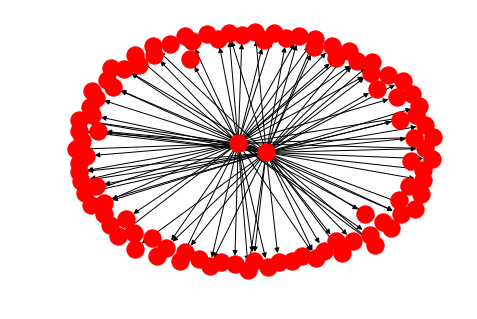

In [44]:
nx.draw(G)

In [45]:
np.nonzero(org_adj_mat)

(array([ 0,  1,  1,  1,  1,  1,  1,  2,  2,  3,  3,  4,  5,  5,  5,  5,  6,
         6,  7,  7,  7,  7,  8, 10, 10, 10, 10, 11, 12, 12, 12, 12, 12, 12,
        13, 13, 14, 15, 15, 18, 18, 19, 19, 19, 20, 22, 22, 23, 24, 24, 25,
        25, 25, 25, 25, 25, 25, 26, 26, 27, 27, 27, 29, 29, 29, 30, 31, 31,
        31, 31, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 35, 35, 36, 37,
        37, 38, 38, 39, 40, 42, 43, 43, 43, 44, 44, 45, 45, 45, 46, 46, 46,
        47, 48, 49, 49, 50, 50, 50, 51, 51, 53, 53, 53, 54, 54, 54, 55, 55,
        55, 57, 58, 58, 58, 59, 59, 59, 59, 60, 61, 61, 62, 64, 64, 66, 66,
        67, 67, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 71,
        72, 72, 73, 73, 74, 75, 76, 77, 77, 78, 78, 79, 79, 83, 83, 83, 84,
        84, 84, 85, 86, 86, 87, 87, 87, 88, 88, 88, 90, 90, 90, 90, 91, 91,
        91, 92, 92, 94, 94, 95, 95, 95, 96, 96, 97, 98, 99]),
 array([37,  7, 46, 52, 62, 90, 94,  4,  9,  4, 49, 30, 28, 45, 60, 67, 51,
        59,  4, 19, 43, 75

In [46]:
for i in range(10) :
    if i == 4 :
        print('balh')
        continue
    print(i)

0
1
2
3
balh
5
6
7
8
9
